# Macrogenesismodel

## Table of contens

1. Introduction 
2. preparation of XML files by parsing and collecting specific elements
3. relation-element graphs<br>
    3.1. graph for tempsyn relation-elements<br>
    3.2. graph for temppre relation-elements
4. date-element graph & the whole graph
5. First analysis ideas & concepts<br>
    5.1. Rank sources by normed research scores <br>
    5.2. Removing nodes and edges by critical sources<br>
6. ...<br>
    6.1. Performance comparison of all approaches<br>
TODO

In [1]:
from faust_macrogen_graph import parserutils, analyzeutils, graphutils, eades_fas
from macrogenesismodel import fas_test, gengraph
from pathlib import Path
import pandas as pd
from collections import Counter, OrderedDict
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display, HTML
    
special_researchers = {'faust://bibliography/gsa-datenbank' : 1950, 
                     'faust://self' : 2000, 
                     'faust://bibliography/inventare_2_2': 2011, 
                     'faust://bibliography/aa_duw_2': 1974,
                     'faust://print/faustedition/J.2': 1887, 
                     'faust://bibliography/quz_1': 1966, 
                     'faust://bibliography/quz_2': 1982, 
                     'faust://bibliography/quz_3': 1986,
                     'faust://bibliography/quz_4': 1984,
                     'faust://bibliography/wa_I_13_2': 1901, 
                     'faust://bibliography/wa_I_14' : 1887, 
                     'faust://bibliography/wa_I_15_2' : 1888, 
                     'faust://bibliography/wa_I_53': 1914,
                     'faust://bibliography/wa_IV_13' : 1893}

## 1. Introduction

In this notebook we take a detailed look at the macrogenesis of the <b>Faust</b> edition. As explained in the Readme (see: <i>Readme.md</i>), the manuscripts hold the problem that a ordering of all these manuscript by dates isn't possible. One of the reasons are the contradictory datings. These are due to the fact that the inclusion of the various research opinions induces differently. The goal of the macrogenesis is to create an order with a <b>graph</b> as structure.<br> A graph can be sorted topologically and thus realize the goal of the ordered macrogenesis. To create a topological order the graph has to be acyclic. Due to the contradictions, however, it is not acyclic. To obtain an acyclic graph, edges must be removed. The removed set of edges is called <b>FAS</b> (= Feedback Arc Set or Feedback Edge Set).

TODO: ...

This notebook will be based on three main questions(?):
1. How can we integrate the absolute datings? How does the FAS look like with and without absolute datings?
2. Can a more detailed analysis of the number of edges and the number of contradictions be helpful to decide which edges of which source should be removed?
3. Can erroneously removed edges be re-added without sacrificing performance? How can this be done and how many edges can be re-added?

TODO: explaination of steps (first some parameters, which will be tested later more detailed)
Now follows a short overview of the sections:<br>
<b>Section 2,3,4</b>: In this section we create the graph out of three different graphs. In section 3 we generate graphs based on the @temppre- and @tempsyn-relation-elements. In section 4 we combine the two relation-graphs with a generated graph based on the date-elements. Unlike the other two graphs, there are several variants of the date-graph, which is due to the different approaches how to implement the absolute dates. We partly answer the first main question how the integration of the absolute datings look like by comparing the different approaches and choosing the best performing approach for the integration into the graph(?). A deeper and more detailed comparison of the approaches will appear in <b>section 5.3 </b>(?).<br>
<b>Section 5</b>: partly answer of question 2, more in chapter 6



TODO: more, überarbeiten

## 2. preparation of XML files by parsing and collecting specific elements

The <i>xmlparser</i>-function can take upt ot four arguments: 
1. the path to the XML files
2. A boolean, if the parser should parse the date- or relation-elements
3. A boolean, if the parser should parse the @temppre- or @tempsyn-relation-elements when it parses the relation-elements
4. A boolean, if the date-elements with the @ignore=yes-attribute will be skipped or not.

In [2]:
filespath = Path('resources')
temppre_items = parserutils.xmlparser(filespath)
tempsyn_items = parserutils.xmlparser(filespath, False, False)
date_items = parserutils.xmlparser(filespath, True, skipignore=False)

## 3. relation-element graphs

TODO<br>
explain everything (introduction)<br>
using eades (baharev?)<br>
what is the goal?<br>
how we proceed?<br>

### 3.1. graph for tempsyn relation-elements

First we create a graph only based of the relation-elements with the @tempsyn-attribute. We use this graph later for adding it with the graph based on the relation-elements with the @temppre-attribute and the date-elements. 
TODO

In [3]:
tempsynG = nx.DiGraph()
for t in tempsyn_items:
    graphutils.add_egdes_from_node_list(tempsynG, t)

We check if the removal of a computed FAS makes the graph acyclic. 

In [4]:
if nx.is_directed_acyclic_graph(tempsynG) == True:
    print("The tempsyn graph is acyclic!")
else:
    tempsynG_fas = eades_fas.eades_FAS(tempsynG, True)

    #atempysnG = acyclic tempsyn Graph
    atempsynG = tempsynG.copy()
    atempsynG.remove_edges_from(tempsynG_fas)
    if nx.is_directed_acyclic_graph(atempsynG) == True:
        print("The tempsyn graph without the FAS (" + str(len(tempsynG_fas)) + " edges) is acyclic!")

The tempsyn graph without the FAS (8 edges) is acyclic!


### 3.2. graph for temppre relation-elements 

Same approach as with the @tempsyn-relation-elements (see 2.1).

In [5]:
temppreG = nx.DiGraph()
for t in temppre_items:
    graphutils.add_egdes_from_node_list(temppreG, t)

In [6]:
if nx.is_directed_acyclic_graph(temppreG) == True:
    print("The temppre graph is acyclic!")
else:
    temppreG_fas = eades_fas.eades_FAS(temppreG, True)
    #atemppreG = acyclic temppre Graph
    atemppreG = temppreG.copy()
    atemppreG.remove_edges_from(temppreG_fas)
    if nx.is_directed_acyclic_graph(atemppreG) == True:
        print("The temppre graph without the FAS (" + str(len(temppreG_fas)) + " edges) is acyclic!")

The temppre graph without the FAS (68 edges) is acyclic!


## 4. date-element graph & the whole graph

TODO: überarbeiten und erklären was hier gemacht wird

We got for the creation of the date graph several approaches of which three doesn't induce a FAS. As shown by the DataFrame <b>dgadf</b> (= date graphs approaches DataFrame), only the approach of <b>Vitt</b> induces a FAS by itself. The reason behind this is that the other approaches are not designed to work by themselves.

In [7]:
approaches = ["vitt", "wissenbach", "paulus-1", "paulus-2"]

approaches_graphs = {}
approaches_fas =  {}

for approach in approaches:
    datesG = graphutils.graph_from_dates(date_items, approach, special_researchers)
    approaches_graphs[approach] = datesG
    datesG_fas = eades_fas.eades_FAS(datesG, True)
    #adatesG = acyclic dates graph
    adatesG = datesG.copy()
    adatesG.remove_edges_from(datesG_fas)
    
    
    approaches_fas[approach] = datesG_fas

date_graphs_approaches = {}
columns = ["n nodes", "n edges", "n cycles", "n feedback edges"]

for k, v in approaches_graphs.items():
    #if k in approaches_fas:
    date_graphs_approaches[k] = [len(v.nodes()), len(v.edges()), len(list(nx.simple_cycles(v))), len(approaches_fas[k])]

approach_df = pd.DataFrame(date_graphs_approaches)#, columns=columns)
approach_df = approach_df.T
approach_df.columns = columns
approach_df

,n nodes,n edges,n cycles,n feedback edges
vitt,731,687,18,18
wissenbach,689,441,0,0
paulus-1,655,441,0,0
paulus-2,649,441,0,0


TODO<br>
For a more meaningful comparison between the approaches we have to create a graph ot of the tempsyn-, temppre- and date-graphs which will in the end represent the desired graph on which we will work on.

In [8]:
approaches = ["vitt", "wissenbach", "paulus-1", "paulus-2"]

approaches_graphs = {}
approaches_fas =  {}

#TODO
tmpG = temppreG #nx.compose(temppreG, tempsynG)

for approach in approaches:
    datesG = graphutils.graph_from_dates(date_items, approach, special_researchers)
    G = nx.compose(tmpG, datesG)
    
    approaches_graphs[approach] = G
    G_fas = eades_fas.eades_FAS(G, True)
    #adatesG = acyclic dates graph
    aG = G.copy()
    aG.remove_edges_from(G_fas)

    approaches_fas[approach] = G_fas

graphs_approaches = {}
columns = ["n nodes", "n edges", "n cycles", "n feedback edges"]

for k, v in approaches_graphs.items():
    #if k in approaches_fas:
    graphs_approaches[k] = [len(v.nodes()), len(v.edges()), len(list(nx.simple_cycles(v))), len(approaches_fas[k])]

approach_df = pd.DataFrame(graphs_approaches)#, columns=columns)
approach_df = approach_df.T
approach_df.columns = columns
approach_df

,n nodes,n edges,n cycles,n feedback edges
vitt,967,1643,1711,120
wissenbach,925,1397,480,68
paulus-1,891,1397,480,68
paulus-2,885,1397,480,68


TODO. more approaches? explain approaches?<br>
The new comparison shows that the <b>Vitt</b>-approach superior to the other approaches. From now one we will take the Vitt-approach to represent the date-elements within the graph. 

In [9]:
datesG = graphutils.graph_from_dates(date_items, "vitt", special_researchers)
G = nx.compose(tmpG, datesG)
G_fas = eades_fas.eades_FAS(G, True)
aG = G.copy()
aG.remove_edges_from(G_fas)
if nx.is_directed_acyclic_graph(aG) == True:
    print("The dates graph is acyclic!")

The dates graph is acyclic!


TODO
The FAS for the whole Graph contains 132 edges. The whole graph G contains 1677 edges, so 7% of all edges are in the FAS. This percentage is too high and several solution approaches should be tried out to reduce the percentage.

In [10]:
print(str(int((len(G_fas) / len(G.edges())) * 100)) 
      + "% of all edges (" + str(len(G.edges())) 
      + ") of G are in the FAS (" + str(len(G_fas)) + " edges).")

7% of all edges (1643) of G are in the FAS (120 edges).


## 5. First analysis ideas & concepts

### 5.1 Rank sources by normed research scores

In this chapter we take a look at the source attributes of the edges. In the XML files, a dating is attested by a source. The problem is that these sources contradict each other which is certainly the reason for the existance of the FAS. To make the graph acyclic, we have to get rid of these contradictory statements.<br>
We parse through the "source"-attributes of the edges of the graph and return a Counter with a frequency score assigned to each researcher. The idea behind this is that a researcher who contributed more than others will get a much higher score. The problem is that by this method quantity surpasses quality. It is not that simple to compare two academic works by its quality and the resulting benefit for the research because the comparison possibilities are manifold and a detailed comparison would exceed this work. As simplification we adjust the scores by multiplying each score with a normalized year of the publication of the researchers work about <b>Faust</b>.

<u>An example</u>: <br>
Anne Bohnenkamp released her work „… das Hauptgeschäft nicht außer Augen lassend“ 1994. Her work is used as source 355 times in the Faustedition. After the "Weimarer Ausgabe, Abt. I, Bd. 15,2, Weimar 1888 (wa_I_15_2) she is the most named source for datings. 

min_range: 1770 (Goethe began to work on his "Urfaust" 1770) <br>
max_range: 2017 (According to http://www.faustedition.net/bibliography, the youngest considered work about Faust beside the Faustedition is <i>Brüning / Hahn 2017</i>.)

Bohnenkamp 1994: 355 * ((1994 - 1770) / (2017 - 1770)) = 321.9433198380567

After the normalization Bohnenkamp surpasses the "wa_I_15_2" (see the source DataFrame <i>source_df</i>). We simply assume in this work that datings of newer works are better and more accurately than older works. One of the reasonings behind this is that newer works are able to make their statements against the background of older researchs, while the older researchs are unable to do so. The normalized score will be used in the next section.

In [11]:
year_scores = analyzeutils.get_source_year(G, special_researchers)
year_df = pd.DataFrame(year_scores.items(), columns=["source", "year"])
year_df.set_index("source", inplace=True)

In [12]:
#df with research count scores
research_scores = analyzeutils.get_research_score(G)
sorted_research_scores = {k: research_scores[k] 
                              for k in sorted(research_scores, key=research_scores.get, reverse=True)}
research_df = pd.DataFrame(sorted_research_scores.items(), columns=["source", "year_frequency"])
research_df.set_index("source", inplace=True)

#df with normed research count scores
norm_research_scores = analyzeutils.get_norm_research_score(G, special_researchers, 1770, 2017)
sorted_norm_research_scores = {k: norm_research_scores[k]
                              for k in sorted(norm_research_scores, key=norm_research_scores.get, reverse=True)}

norm_research_df = pd.DataFrame(sorted_norm_research_scores.items(), columns=["source", "norm_year_frequency"])
norm_research_df.set_index("source", inplace=True)


#combinig the three dfs

source_df = research_df.join(norm_research_df)
source_df[:10]

,year_frequency,norm_year_frequency
source,,
faust://bibliography/wa_I_15_2,450,214.979757
faust://bibliography/fischer-lamberg1955,345,258.400810
faust://bibliography/bohnenkamp1994,337,305.619433
faust://self,140,130.364372
faust://bibliography/landeck1981,136,116.178138
faust://bibliography/hertz1932,69,45.255061
faust://bibliography/inventare_2_2,26,25.368421
faust://bibliography/gsa-datenbank,26,18.947368
faust://bibliography/hertz1931,12,7.821862


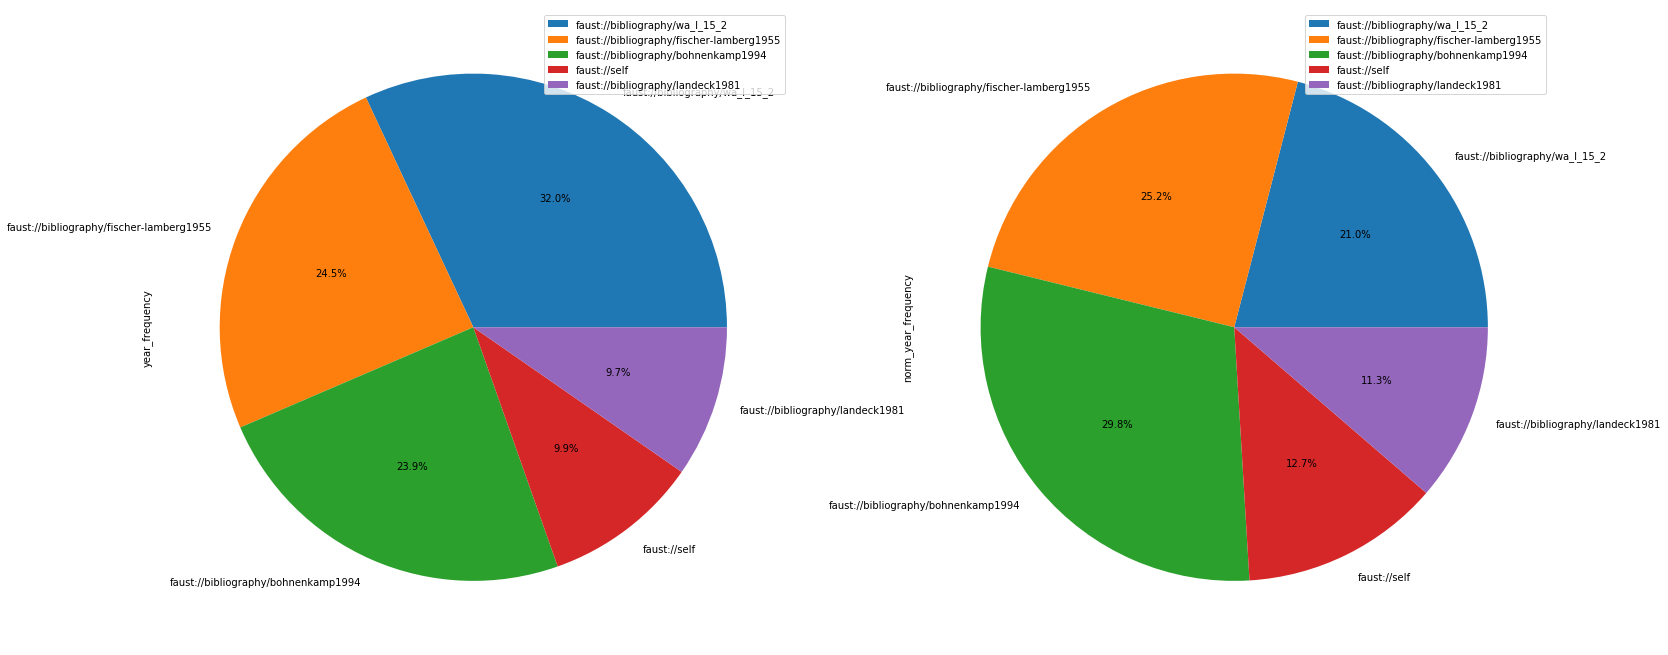

In [13]:
plot = source_df[:5].plot.pie(subplots=True, figsize=(25,25), autopct='%.1f%%')
plt.show()

In [14]:
#adding df with publication year of the source to the source_df
year_scores = analyzeutils.get_source_year(G, special_researchers)
year_df = pd.DataFrame(year_scores.items(), columns=["source", "pub_year"])
year_df.set_index("source", inplace=True)

source_df = source_df.join(year_df)
source_df[:10]
#Note: If the following (or similiar) Error raises, restart the code cell with the "source_df"-variable
#ValueError: columns overlap but no suffix specified: Index(['percent_fas', 'norm_percent_fas'], dtype='object')

,year_frequency,norm_year_frequency,pub_year
source,,,
faust://bibliography/wa_I_15_2,450,214.979757,1888
faust://bibliography/fischer-lamberg1955,345,258.400810,1955
faust://bibliography/bohnenkamp1994,337,305.619433,1994
faust://self,140,130.364372,2000
faust://bibliography/landeck1981,136,116.178138,1981
faust://bibliography/hertz1932,69,45.255061,1932
faust://bibliography/inventare_2_2,26,25.368421,2011
faust://bibliography/gsa-datenbank,26,18.947368,1950
faust://bibliography/hertz1931,12,7.821862,1931


With the normalized TODO

### 5.2 Removing nodes and edges by critical sources

After the normalization of the source counts we have to take a deeper look at the <b>Feedback Arc Set</b>. The FAS contains 135 edges. More than a third of the FAS is taken up by "wa_I_15_2" and more than twice as much as the second, third and fourth most common sources by "fischer-lamberg1955", "bohnenkamp1994" and "landeck1981" (see the FAS-frequency DataFrame <i>fasfrequency_df</i>).<br> In this section we try to bypass the computed FAS by trying to make the graph <b>G</b> acylic with the removal of specific sources. We rely on the normed research score of the previous section (see 5.1). The idea behind this is that the FAS has a certain randomness because it tries to compute a minimal solution for the problem (at least if we use the <b>Eades</b> or any other MFAS algorithm). This holds the problem that the removal of the edges to make the graph <b>G</b> acyclic and its randomness makes little sense with regards of content. Against the background of an ideal solution which returns a perfect sorting, the goal is rather to find critical, conflicting sources. Nevertheless, we use the FAS to filter for critical sources and take a closer look a the sources who have the most edges within the FAS.

For a better content but also visual comparison we will use the datastructure <i>DataFrame</i> from the <i>pandas library</i>. The DataFrame <i>df</i> which represents the comparison will be build step by step. The sources of the edges of the FAS determine the index of the DataFrame and the

- frequency of the researcher as manuscript source
- normed frequency of the researcher as manuscript source
- publication year of the source
- frequency of the researcher as source of an edge in the FAS
- percentage which determines how many edges of an researcher are in the FAS
- percentage which determines how many edges of an researcher (based on the normalized year frequency) are in the FAS

determine the six columns. Each of these columns will be first stored in a DataFrame and later added to the "main"-DataFrame <i>df</i> which is gradually being expanded.
<br>TODO: more!?

In [15]:
#frequency of the researcher as manuscript source
fas_source_counter = Counter()
for edge in G_fas:
    if G.has_edge(edge[0], edge[1]):
        edge_data = G.get_edge_data(edge[0], edge[1])
        key = edge_data["source"]
        if fas_source_counter[key]:
            fas_source_counter[key] += 1
        else:
            fas_source_counter[key] = 1

            
fasfrequency_df = pd.DataFrame.from_dict(OrderedDict(fas_source_counter.most_common()), 
                                         orient="index").reset_index()
fasfrequency_df = fasfrequency_df.rename(columns={"index":"source", 0:"fas_frequency"})
fasfrequency_df.set_index("source", inplace=True)
fasfrequency_df

,fas_frequency
source,
faust://bibliography/wa_I_15_2,52
faust://bibliography/fischer-lamberg1955,23
faust://bibliography/bohnenkamp1994,18
faust://bibliography/landeck1981,13
faust://self,3
faust://bibliography/pniower1899,3
faust://bibliography/hertz1932,3
faust://bibliography/wa_I_14,1
faust://bibliography/bluhm1966,1


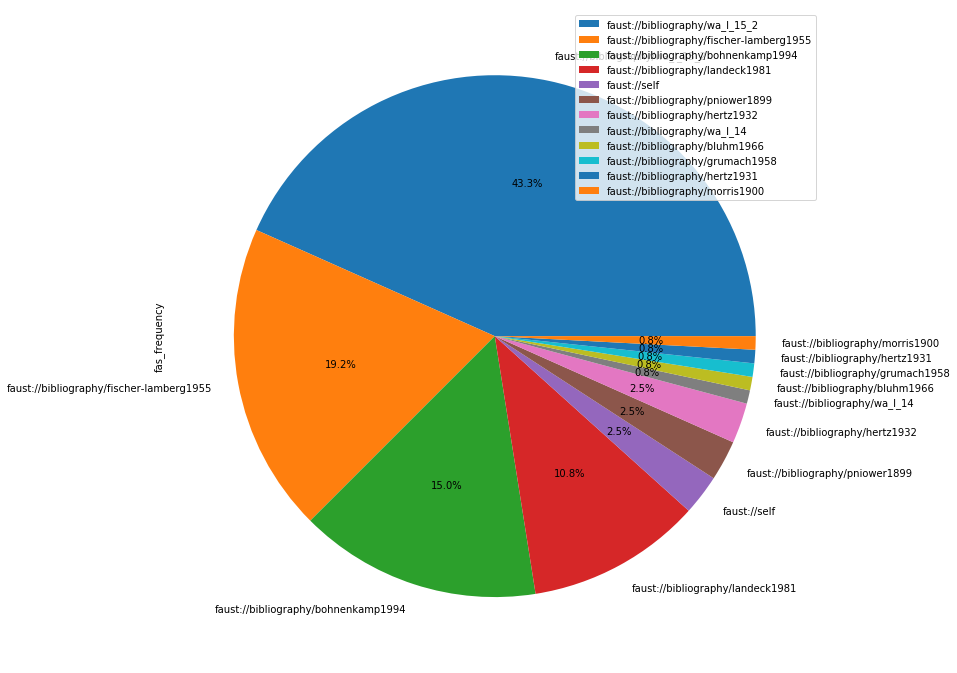

In [16]:
plot = fasfrequency_df.plot.pie(y="fas_frequency", figsize=(12, 12), autopct='%.1f%%')
plt.show()

In [36]:
df = source_df.join(fasfrequency_df)
df = df.dropna() #only sources which are inside the FAS
df

,year_frequency,norm_year_frequency,pub_year,fas_frequency
source,,,,
faust://bibliography/wa_I_15_2,450,214.979757,1888,52.0
faust://bibliography/fischer-lamberg1955,345,258.400810,1955,23.0
faust://bibliography/bohnenkamp1994,337,305.619433,1994,18.0
faust://self,140,130.364372,2000,3.0
faust://bibliography/landeck1981,136,116.178138,1981,13.0
faust://bibliography/hertz1932,69,45.255061,1932,3.0
faust://bibliography/hertz1931,12,7.821862,1931,1.0
faust://bibliography/wa_I_14,10,4.736842,1887,1.0
faust://bibliography/pniower1899,7,3.655870,1899,3.0


In [18]:
percent_fas = (df["fas_frequency"] / df["year_frequency"]) * 100
norm_percent_fas = (df["fas_frequency"] / df["norm_year_frequency"]) * 100
percentfas_df = pd.concat([percent_fas, norm_percent_fas], axis=1, sort=True)
percentfas_df = percentfas_df.rename(columns={0:"percent_fas", 1:"norm_percent_fas"})
percentfas_df.sort_values(by="percent_fas", ascending=False)
df = df.join(percentfas_df, on="source")
df
#Note: If the following Error raises, restart the code cell with the "df"-variable and it should work
#ValueError: columns overlap but no suffix specified: Index(['percent_fas', 'norm_percent_fas'], dtype='object')

,year_frequency,norm_year_frequency,pub_year,fas_frequency,percent_fas,norm_percent_fas
source,,,,,,
faust://bibliography/wa_I_15_2,450,214.979757,1888,52.0,11.555556,24.188324
faust://bibliography/fischer-lamberg1955,345,258.400810,1955,23.0,6.666667,8.900901
faust://bibliography/bohnenkamp1994,337,305.619433,1994,18.0,5.341246,5.889678
faust://self,140,130.364372,2000,3.0,2.142857,2.301242
faust://bibliography/landeck1981,136,116.178138,1981,13.0,9.558824,11.189713
faust://bibliography/hertz1932,69,45.255061,1932,3.0,4.347826,6.629093
faust://bibliography/hertz1931,12,7.821862,1931,1.0,8.333333,12.784679
faust://bibliography/wa_I_14,10,4.736842,1887,1.0,10.000000,21.111111
faust://bibliography/pniower1899,7,3.655870,1899,3.0,42.857143,82.059801


For answering the question which complete source we want to remove to make the Graph acyclic without computing a FAS, we rely on several characteristics a source should have to be rather removed from the Graph than other sources:
1. Very old source 
2. Small amount of edges in the Graph
3. Resulting from (1) and (2) a high <b>norm_percent_fas</b>-score.
4. ? TODO

If a source meets many of the mentioned characteristics, we remove every edge with the source as attribute and compare how much the FAS shrinkes afterwards.

First we get a sorted list of the sources and their <b>norm_percent_fas</b>-score.

In [19]:
critical_sources = {}
param = 0
for k, v in dict(df["norm_percent_fas"]).items():
    if v >= param:
        critical_sources[k] = v
critical_sources = [(k, critical_sources[k]) for k in sorted(critical_sources, key=critical_sources.get, reverse=True)]        
critical_sources

[('faust://bibliography/morris1900', 95.0),
 ('faust://bibliography/pniower1899', 82.05980066445181),
 ('faust://bibliography/bluhm1966', 63.01020408163265),
 ('faust://bibliography/wa_I_15_2', 24.188323917137474),
 ('faust://bibliography/grumach1958', 21.897163120567377),
 ('faust://bibliography/wa_I_14', 21.111111111111114),
 ('faust://bibliography/hertz1931', 12.784679089026914),
 ('faust://bibliography/landeck1981', 11.189712851965432),
 ('faust://bibliography/fischer-lamberg1955', 8.900900900900902),
 ('faust://bibliography/hertz1932', 6.629092860976919),
 ('faust://bibliography/bohnenkamp1994', 5.889677829588808),
 ('faust://self', 2.3012422360248443)]

Then we remove every source of the <b>critical sources</b>-list from the graph and store the reduced <b>FAS</b> with the assigned source in dictionary.

In [20]:
critical_sources_fas = {}
for critical_source in critical_sources:
    F = G.copy()
    for edge in list(F.edges()):
        edge_data = F.get_edge_data(edge[0], edge[1])
        if edge_data["source"] == critical_source[0]:
            F.remove_edge(edge[0], edge[1])
    F_fas = eades_fas.eades_FAS(F, True)
    critical_sources_fas[critical_source[0]] = len(F_fas)
critical_sources_fas

{'faust://bibliography/morris1900': 122,
 'faust://bibliography/pniower1899': 116,
 'faust://bibliography/bluhm1966': 115,
 'faust://bibliography/wa_I_15_2': 45,
 'faust://bibliography/grumach1958': 119,
 'faust://bibliography/wa_I_14': 119,
 'faust://bibliography/hertz1931': 119,
 'faust://bibliography/landeck1981': 100,
 'faust://bibliography/fischer-lamberg1955': 74,
 'faust://bibliography/hertz1932': 103,
 'faust://bibliography/bohnenkamp1994': 89,
 'faust://self': 116}

In [35]:
criticals_df = pd.DataFrame(critical_sources_fas, columns=["source", "fas_without_source"])
criticals_df.set_index("source", inplace=True)
df = df.join(criticals_df)
df
#Note: If the following Error raises, restart the code cell with the creation of "df" and it should work
#ValueError: columns overlap but no suffix specified: Index(['percent_fas', 'norm_percent_fas'], dtype='object')

ValueError: columns overlap but no suffix specified: Index(['fas_without_source'], dtype='object')

We now take a look at the sources which didn't appear in the "original" FAS and add them to the <b>possible_critical_sources</b>-dictionary if a removal of these sources reduce the FAS.

In [34]:
#TODO explain (die möglichen FAS kandidaten die durch df.drop_na außen vorgelassen wurden)

scores = dict(analyzeutils.get_research_score(G))

critical_sources_fas = {}
for score in scores:
    F = G.copy()
    for edge in list(F.edges()):
        edge_data = F.get_edge_data(edge[0], edge[1])
        if edge_data["source"] == score:
            F.remove_edge(edge[0], edge[1])
    F_fas = eades_fas.eades_FAS(F, True)
    critical_sources_fas[score] = len(F_fas)
critical_sources_fas = [(k, critical_sources_fas[k]) for k in sorted(critical_sources_fas, key=critical_sources_fas.get, reverse=True)]
possible_critical_sources = {}
for t in critical_sources_fas:
    #TODO
    if t[0] not in list(df.index.values) and t[1] < 120:
        possible_critical_sources[t[0]] = t[1]
possible_critical_sources

KeyboardInterrupt: 

In this section we:
- build a DataFrame <i>df</i> where we took the sources of the FAS as index and several characteristics like publication year, the frequency of the source inside the FAS or the size of the FAS without the source as columns
- computed a dictionary with possible critical sources which aren't in the "original" FAS but could reduce the FAS when they would be removed (?)
- TODO: noch was?

## 6. Manipulating (?) approaches

### 6.1 Performance comparison of all current approaches

In this section we compare all of the current approaches and look at their performance. We already did this in a light variant in <b>section 4</b>. There we decided to take the Vitt approach because the computed graph hold more nodes and egdes than the other approaches. We now prove prove in more detail why using Vitt-approach is the best solution for us(?).<br>
Instead of simply compare the approaches by the number of nodes and edges, we also test if the ignoring of the skipignore-elements and changing of the <b>Eades</b>-MFAS-algorihtm to the variant of <b>Tintelnot</b> make(?) any big difference (?).
TODO

In [23]:
#paramlist = [approach, skipignore, eades_fas or tintelnot_fas]
metaparamdict = {"vitt(+skipignore, tintelnot)" : ["vitt", True, True], 
                 "vitt(-skipignore, tintelnot)" : ["vitt", False, True],
                "vitt(+skipignore, eades)" : ["vitt", True, False], 
                 "vitt(-skipignore, eades)" : ["vitt", False, False],
                "wissenbach(+skipignore, tintelnot)" : ["wissenbach", True, True], 
                 "wissenbach(-skipignore, tinelnot)" : ["wissenbach", False, True],
                "wissenbach(+skipignore, eades)" : ["wissenbach", True, False], 
                 "wissenbach(-skipignore, eades)" : ["wissenbach", False, False],
                 "paulus-1(+skipignore, tintelnot)" : ["paulus-1", True, True], 
                 "paulus-1(-skipignore, tinelnot)" : ["paulus-1", False, True],
                "paulus-1(+skipignore, eades)" : ["paulus-1", True, False], 
                 "paulus-1(-skipignore, eades)" : ["paulus-1", False, False],
                 "paulus-2(+skipignore, tintelnot)" : ["paulus-2", True, True], 
                 "paulus-2(-skipignore, tinelnot)" : ["paulus-2", False, True],
                "paulus-2(+skipignore, eades)" : ["paulus-2", True, False], 
                 "paulus-2(-skipignore, eades)" : ["paulus-2", False, False],
                }
meta_fas_test_dict = {}

for key, paramlist in metaparamdict.items():
    meta_fas_test_dict[key] = fas_test(paramlist, special_researchers)

In [24]:
meta_param_df = pd.DataFrame(meta_fas_test_dict)
meta_param_df = meta_param_df.T
meta_param_df = meta_param_df.drop("nodeslist", 1)
meta_param_df

,cycles,edges,fas,fasfrequency_df,nodes,percentfas_df,source_df
"vitt(+skipignore, tintelnot)",1711,1643,120,fas_...,965,perc...,year...
"vitt(-skipignore, tintelnot)",1711,1643,120,fas_...,967,perc...,year...
"vitt(+skipignore, eades)",1711,1643,120,fas_...,965,perc...,year...
"vitt(-skipignore, eades)",1711,1643,120,fas_...,967,perc...,year...
"wissenbach(+skipignore, tintelnot)",480,1397,68,fas_...,925,perc...,year...
"wissenbach(-skipignore, tinelnot)",480,1397,68,fas_...,925,perc...,year...
"wissenbach(+skipignore, eades)",480,1397,68,fas_...,925,perc...,year...
"wissenbach(-skipignore, eades)",480,1397,68,fas_...,925,perc...,year...
"paulus-1(+skipignore, tintelnot)",480,1397,68,fas_...,891,perc...,year...
"paulus-1(-skipignore, tinelnot)",480,1397,68,fas_...,891,perc...,year...


In [25]:
metadfdict = {"fasfrequency_df" : ["fas_frequency"], 
              "percentfas_df": ["percent_fas","norm_percent_fas"], 
              "source_df": ["year_frequency", "norm_year_frequency"]}



for dataframe, columns in metadfdict.items():
    for column in columns:
        tmp_df = analyzeutils.dataframe_from_column(meta_param_df, dataframe, column)
        print(column)
        display(HTML(tmp_df.to_html()))
        print("\n")

fas_frequency


,"vitt(+skipignore, tintelnot)","vitt(-skipignore, tintelnot)","vitt(+skipignore, eades)","vitt(-skipignore, eades)","wissenbach(+skipignore, tintelnot)","wissenbach(-skipignore, tinelnot)","wissenbach(+skipignore, eades)","wissenbach(-skipignore, eades)","paulus-1(+skipignore, tintelnot)","paulus-1(-skipignore, tinelnot)","paulus-1(+skipignore, eades)","paulus-1(-skipignore, eades)","paulus-2(+skipignore, tintelnot)","paulus-2(-skipignore, tinelnot)","paulus-2(+skipignore, eades)","paulus-2(-skipignore, eades)"
faust://bibliography/bluhm1966,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/bohnenkamp1994,18.0,18.0,18.0,18.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
faust://bibliography/fischer-lamberg1955,23.0,23.0,23.0,23.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0
faust://bibliography/grumach1958,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/hertz1931,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/hertz1932,3.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/inventare_2_2,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
faust://bibliography/landeck1981,13.0,13.0,13.0,13.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
faust://bibliography/morris1900,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/pniower1899,3.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




percent_fas


,"vitt(+skipignore, tintelnot)","vitt(-skipignore, tintelnot)","vitt(+skipignore, eades)","vitt(-skipignore, eades)","wissenbach(+skipignore, tintelnot)","wissenbach(-skipignore, tinelnot)","wissenbach(+skipignore, eades)","wissenbach(-skipignore, eades)","paulus-1(+skipignore, tintelnot)","paulus-1(-skipignore, tinelnot)","paulus-1(+skipignore, eades)","paulus-1(-skipignore, eades)","paulus-2(+skipignore, tintelnot)","paulus-2(-skipignore, tinelnot)","paulus-2(+skipignore, eades)","paulus-2(-skipignore, eades)"
faust://bibliography/bluhm1966,50.000000,50.000000,50.000000,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/bohnenkamp1994,5.341246,5.341246,5.341246,5.341246,1.153846,1.153846,1.153846,1.153846,1.153846,1.153846,1.153846,1.153846,1.153846,1.153846,1.153846,1.153846
faust://bibliography/fischer-lamberg1955,6.666667,6.666667,6.666667,6.666667,5.084746,5.084746,5.084746,5.084746,5.084746,5.084746,5.084746,5.084746,5.084746,5.084746,5.084746,5.084746
faust://bibliography/grumach1958,16.666667,16.666667,16.666667,16.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/hertz1931,8.333333,8.333333,8.333333,8.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/hertz1932,4.347826,4.347826,4.347826,4.347826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/inventare_2_2,NaN,NaN,NaN,NaN,2.564103,2.564103,2.564103,2.564103,2.564103,2.564103,2.564103,2.564103,2.564103,2.564103,2.564103,2.564103
faust://bibliography/landeck1981,9.558824,9.558824,9.558824,9.558824,3.200000,3.200000,3.200000,3.200000,3.200000,3.200000,3.200000,3.200000,3.200000,3.200000,3.200000,3.200000
faust://bibliography/morris1900,50.000000,50.000000,50.000000,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/pniower1899,42.857143,42.857143,42.857143,42.857143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




norm_percent_fas


,"vitt(+skipignore, tintelnot)","vitt(-skipignore, tintelnot)","vitt(+skipignore, eades)","vitt(-skipignore, eades)","wissenbach(+skipignore, tintelnot)","wissenbach(-skipignore, tinelnot)","wissenbach(+skipignore, eades)","wissenbach(-skipignore, eades)","paulus-1(+skipignore, tintelnot)","paulus-1(-skipignore, tinelnot)","paulus-1(+skipignore, eades)","paulus-1(-skipignore, eades)","paulus-2(+skipignore, tintelnot)","paulus-2(-skipignore, tinelnot)","paulus-2(+skipignore, eades)","paulus-2(-skipignore, eades)"
faust://bibliography/bluhm1966,63.010204,63.010204,63.010204,63.010204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/bohnenkamp1994,5.889678,5.889678,5.889678,5.889678,1.272321,1.272321,1.272321,1.272321,1.272321,1.272321,1.272321,1.272321,1.272321,1.272321,1.272321,1.272321
faust://bibliography/fischer-lamberg1955,8.900901,8.900901,8.900901,8.900901,6.788823,6.788823,6.788823,6.788823,6.788823,6.788823,6.788823,6.788823,6.788823,6.788823,6.788823,6.788823
faust://bibliography/grumach1958,21.897163,21.897163,21.897163,21.897163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/hertz1931,12.784679,12.784679,12.784679,12.784679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/hertz1932,6.629093,6.629093,6.629093,6.629093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/inventare_2_2,NaN,NaN,NaN,NaN,2.627939,2.627939,2.627939,2.627939,2.627939,2.627939,2.627939,2.627939,2.627939,2.627939,2.627939,2.627939
faust://bibliography/landeck1981,11.189713,11.189713,11.189713,11.189713,3.745972,3.745972,3.745972,3.745972,3.745972,3.745972,3.745972,3.745972,3.745972,3.745972,3.745972,3.745972
faust://bibliography/morris1900,95.000000,95.000000,95.000000,95.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/pniower1899,82.059801,82.059801,82.059801,82.059801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




year_frequency


,"vitt(+skipignore, tintelnot)","vitt(-skipignore, tintelnot)","vitt(+skipignore, eades)","vitt(-skipignore, eades)","wissenbach(+skipignore, tintelnot)","wissenbach(-skipignore, tinelnot)","wissenbach(+skipignore, eades)","wissenbach(-skipignore, eades)","paulus-1(+skipignore, tintelnot)","paulus-1(-skipignore, tinelnot)","paulus-1(+skipignore, eades)","paulus-1(-skipignore, eades)","paulus-2(+skipignore, tintelnot)","paulus-2(-skipignore, tinelnot)","paulus-2(+skipignore, eades)","paulus-2(-skipignore, eades)"
faust://bibliography/aa_duw_2,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
faust://bibliography/bluhm1966,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
faust://bibliography/bohnenkamp1994,337.0,337.0,337.0,337.0,260.0,260.0,260.0,260.0,260.0,260.0,260.0,260.0,260.0,260.0,260.0,260.0
faust://bibliography/bruening_hahn2017,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
faust://bibliography/collin1920,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/duentzer1891a,4.0,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/duentzer1891b,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
faust://bibliography/fischer-lamberg1955,345.0,345.0,345.0,345.0,295.0,295.0,295.0,295.0,295.0,295.0,295.0,295.0,295.0,295.0,295.0,295.0
faust://bibliography/fischer-lamberg1959,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
faust://bibliography/frankenberger1926,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0




norm_year_frequency


,"vitt(+skipignore, tintelnot)","vitt(-skipignore, tintelnot)","vitt(+skipignore, eades)","vitt(-skipignore, eades)","wissenbach(+skipignore, tintelnot)","wissenbach(-skipignore, tinelnot)","wissenbach(+skipignore, eades)","wissenbach(-skipignore, eades)","paulus-1(+skipignore, tintelnot)","paulus-1(-skipignore, tinelnot)","paulus-1(+skipignore, eades)","paulus-1(-skipignore, eades)","paulus-2(+skipignore, tintelnot)","paulus-2(-skipignore, tinelnot)","paulus-2(+skipignore, eades)","paulus-2(-skipignore, eades)"
faust://bibliography/aa_duw_2,1.651822,1.651822,1.651822,1.651822,0.825911,0.825911,0.825911,0.825911,0.825911,0.825911,0.825911,0.825911,0.825911,0.825911,0.825911,0.825911
faust://bibliography/bluhm1966,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045
faust://bibliography/bohnenkamp1994,305.619433,305.619433,305.619433,305.619433,235.789474,235.789474,235.789474,235.789474,235.789474,235.789474,235.789474,235.789474,235.789474,235.789474,235.789474,235.789474
faust://bibliography/bruening_hahn2017,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
faust://bibliography/collin1920,0.607287,0.607287,0.607287,0.607287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/duentzer1891a,1.959514,1.959514,1.959514,1.959514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/duentzer1891b,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879
faust://bibliography/fischer-lamberg1955,258.400810,258.400810,258.400810,258.400810,220.951417,220.951417,220.951417,220.951417,220.951417,220.951417,220.951417,220.951417,220.951417,220.951417,220.951417,220.951417
faust://bibliography/fischer-lamberg1959,NaN,NaN,NaN,NaN,0.765182,0.765182,0.765182,0.765182,0.765182,0.765182,0.765182,0.765182,0.765182,0.765182,0.765182,0.765182
faust://bibliography/frankenberger1926,1.263158,1.263158,1.263158,1.263158,0.631579,0.631579,0.631579,0.631579,0.631579,0.631579,0.631579,0.631579,0.631579,0.631579,0.631579,0.631579


Analysis:
- no difference between the Eades and Tintelnot FAS for our graph
- Wissenbach- and Paulus-approaches induces more NaN-Values than the Vitt-approach
- the skipignore has only a small impact: it adds "pniower1924" to the year_frequency DataFrame, but doesn't impact the other DataFrames (it doesn't appear inside the FAS)

So we have shown that taking the Vitt approach has advantages over the other approaches in Section 4 and in this section we proved that the Vitt-approach is the most useful approach for solving our issues. This is not particularly surprising in the Paulus-approaches, as these are basically the Vitt approach when they are jointed. The problem with the Wissenbach approach seems to be that, like the Paulus-approaches, it connects only the one node that represents the middle of the "notBefore" and "notAfter" dates to the manuscript. So it seems that the <b>basic structure</b> of the Vitt approach of representing "notBefore" and "notAfter" as their own nodes and linking them to the manuscript is the most practical solution. In the following we will manipulate the "notBefore" and the "notAfter" dates in the Vitt approach and see how these changes affect the nodes, edges, cycles and the FAS.


TODO

### 6.2 Adjusting of the Vitt-approach

...TODO

In [26]:
#factor can not be 1 (doesn't make not any sense and doesn't work with our algorithm)
metafactordict = {"vitt" : ["vitt", False, True],
                 "shorter(2)" : ["shorter_period", False, True, 2],
                 "shorter(3)" : ["shorter_period", False, True, 3],
                 "shorter(4)" : ["shorter_period", False, True, 4],
                 "shorter(5)" : ["shorter_period", False, True, 5],
                 "shorter(6)" : ["shorter_period", False, True, 6],
                 "shorter(7)" : ["shorter_period", False, True, 7],
                 "shorter(8)" : ["shorter_period", False, True, 8],
                 "shorter(9)" : ["shorter_period", False, True, 9],
                 "shorter(10)" : ["shorter_period", False, True, 10],
                 "shorter(11)" : ["shorter_period", False, True, 11]}


meta_factor_test_dict = {}

for key, paramlist in metafactordict.items():
    meta_factor_test_dict[key] = fas_test(paramlist, special_researchers)

In [27]:
meta_factor_df = pd.DataFrame(meta_factor_test_dict)
meta_factor_df = meta_factor_df.T
meta_factor_df = meta_factor_df.drop('fasfrequency_df', 1)
meta_factor_df = meta_factor_df.drop('percentfas_df', 1)
meta_factor_df = meta_factor_df.drop('source_df', 1)
meta_factor_df

,cycles,edges,fas,nodes,nodeslist
vitt,1711,1643,120,967,"[faust://document/faustedition/H_P9, faust://d..."
shorter(2),21030,1643,217,966,"[faust://document/faustedition/H_P9, faust://d..."
shorter(3),689,1643,105,1035,"[faust://document/faustedition/H_P9, faust://d..."
shorter(4),1179,1643,113,1020,"[faust://document/faustedition/H_P9, faust://d..."
shorter(5),735,1643,103,1022,"[faust://document/faustedition/H_P9, faust://d..."
shorter(6),2653,1643,114,1016,"[faust://document/faustedition/H_P9, faust://d..."
shorter(7),734,1643,108,1013,"[faust://document/faustedition/H_P9, faust://d..."
shorter(8),884,1643,106,1019,"[faust://document/faustedition/H_P9, faust://d..."
shorter(9),856,1643,104,1015,"[faust://document/faustedition/H_P9, faust://d..."
shorter(10),856,1643,110,1019,"[faust://document/faustedition/H_P9, faust://d..."


As we can see here, "shorter (3)" seems to perform best. Compared to the Vitt approach, it has well under half the number of cycles and the FAS is also smaller. Furthermore, it has more nodes than the Vitt approach. That's because there are many more different datings which resulted from the addition and subtraction of days. Therefore the <b>comparison_nodelist</b> contains only datings.

In [28]:
shorter3nodelist = meta_factor_df["nodeslist"]["shorter(3)"]
vittnodeslist = meta_factor_df["nodeslist"]["vitt"]

comparison_nodelist = []

for node in shorter3nodelist:
    if node not in vittnodeslist:
        comparison_nodelist.append(node)
        
comparison_nodelist

['1774-03-30 00:00:00',
 '1775-01-18 00:00:00',
 '1776-05-01 00:00:00',
 '1776-09-01 00:00:00',
 '1780-02-12 00:00:00',
 '1784-05-19 00:00:00',
 '1782-05-02 00:00:00',
 '1782-09-01 00:00:00',
 '1786-08-30 00:00:00',
 '1786-11-30 00:00:00',
 '1787-04-09 00:00:00',
 '1787-11-13 00:00:00',
 '1788-09-01 00:00:00',
 '1788-10-20 00:00:00',
 '1789-04-11 00:00:00',
 '1790-05-01 00:00:00',
 '1790-05-31 00:00:00',
 '1791-05-02 00:00:00',
 '1792-09-01 00:00:00',
 '1796-04-28 00:00:00',
 '1796-11-26 00:00:00',
 '1797-09-10 00:00:00',
 '1797-09-21 00:00:00',
 '1797-10-07 00:00:00',
 '1798-01-20 00:00:00',
 '1798-08-08 00:00:00',
 '1799-09-24 00:00:00',
 '1798-08-16 00:00:00',
 '1798-08-31 00:00:00',
 '1798-08-25 00:00:00',
 '1798-09-05 00:00:00',
 '1798-09-27 00:00:00',
 '1800-01-02 00:00:00',
 '1799-03-11 00:00:00',
 '1800-03-21 00:00:00',
 '1799-04-30 00:00:00',
 '1800-05-01 00:00:00',
 '1799-08-05 00:00:00',
 '1799-09-20 00:00:00',
 '1800-02-01 00:00:00',
 '1800-09-04 00:00:00',
 '1800-04-15 00:

longer

In [29]:
lmetafactordict = {"vitt" : ["vitt", False, True],
                   "longer(1)" : ["longer_period", False, True, 1],
                   "longer(2)" : ["longer_period", False, True, 2],
                   "longer(3)" : ["longer_period", False, True, 3],
                   "longer(4)" : ["longer_period", False, True, 4],
                   "longer(5)" : ["longer_period", False, True, 5],
                   "longer(6)" : ["longer_period", False, True, 6],
                   "longer(7)" : ["longer_period", False, True, 7],
                   "longer(8)" : ["longer_period", False, True, 8],
                   "longer(9)" : ["longer_period", False, True, 9],
                   "longer(10)" : ["longer_period", False, True, 10],
                   "longer(11)" : ["longer_period", False, True, 11]}


lmeta_factor_test_dict = {}

for key, paramlist in lmetafactordict.items():
    lmeta_factor_test_dict[key] = fas_test(paramlist, special_researchers)

In [30]:
lmeta_factor_df = pd.DataFrame(lmeta_factor_test_dict)
lmeta_factor_df = lmeta_factor_df.T
lmeta_factor_df = lmeta_factor_df.drop('fasfrequency_df', 1)
lmeta_factor_df = lmeta_factor_df.drop('percentfas_df', 1)
lmeta_factor_df = lmeta_factor_df.drop('source_df', 1)
lmeta_factor_df

,cycles,edges,fas,nodes,nodeslist
vitt,1711,1643,120,967,"[faust://document/faustedition/H_P9, faust://d..."
longer(1),480,1643,69,1016,"[faust://document/faustedition/H_P9, faust://d..."
longer(2),503,1643,69,1012,"[faust://document/faustedition/H_P9, faust://d..."
longer(3),5592,1643,70,1012,"[faust://document/faustedition/H_P9, faust://d..."
longer(4),620,1643,71,1017,"[faust://document/faustedition/H_P9, faust://d..."
longer(5),481,1643,70,1019,"[faust://document/faustedition/H_P9, faust://d..."
longer(6),1384,1643,69,1014,"[faust://document/faustedition/H_P9, faust://d..."
longer(7),481,1643,68,1015,"[faust://document/faustedition/H_P9, faust://d..."
longer(8),480,1643,68,1022,"[faust://document/faustedition/H_P9, faust://d..."
longer(9),480,1643,69,1025,"[faust://document/faustedition/H_P9, faust://d..."


The best performing approach is "longer(11)", although there aren't many distinct differences between the seperate approaches.

TODO:
1. tempsyn hinzufügen. was machen? andere gewichte?
2. endlich mal Graphen machen

## 7. Creating of the graph 

In [38]:
bestsolutions = {"longer(11)" : ["longer_period", False, True, 11], 
                 "shorter(3)" : ["shorter_period", False, True, 3]}
longerGparams = bestsolutions["longer(11)"]
longerG = gengraph(longerGparams, special_researchers)
longerG_fas = eades_fas.eades_FAS(longerG, True)
longerG.remove_edges_from(longerG_fas)
if nx.is_directed_acyclic_graph(longerG) == True:
    print("The longer graph without the FAS (" + str(len(longerG_fas)) + " edges) is acyclic!") 

The longer graph without the FAS (68 edges) is acyclic!


In [39]:
fas_test(longerGparams, special_researchers)

{'fas': 68,
 'edges': 1643,
 'nodes': 1024,
 'nodeslist': ['faust://document/faustedition/H_P9',
  'faust://document/bohnenkamp/H_P9a',
  'faust://document/faustedition/1_H.10',
  'faust://document/faustedition/H_P27',
  'faust://document/faustedition/H_P50',
  'faust://inscription/faustedition/H_P22/i_2_o',
  'faust://inscription/faustedition/H_P22/i_2_u',
  'faust://document/faustedition/H_P68_Var',
  'faust://document/faustedition/H_P68',
  'faust://document/gsa_1/GSA_25_XIX,4',
  'faust://document/gsa_2/GSA_25_W_1806',
  'faust://inscription/faustedition/H_P65/i_uebrige',
  'faust://inscription/faustedition/H_P65/i_4_r',
  'faust://document/faustedition/2_H.15b',
  'faust://document/faustedition/2_V_H.14',
  'faust://document/faustedition/2_III_H.1',
  'faust://document/wa/2_III_H.2',
  'faust://document/faustedition/2_III_H.2_1',
  'faust://document/faustedition/2_III_H.2a_1',
  'faust://document/wa/2_III_H.7',
  'faust://document/faustedition/2_III_H.2a_5',
  'faust://document/fa